In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score,fbeta_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [6]:
df = pd.read_csv('processed_data.csv')

In [7]:
df.isna().sum()

Client_Income_category            0
Credit_Amount_category            0
Credit_to_Income_Category         0
Loan_Annuity_category             0
Client_Family_Members_Category    0
Car_Owned                         0
Bike_Owned                        0
Active_Loan                       0
Accompany_Client                  0
Client_Income_Type                0
Client_Education                  0
Client_Marital_Status             0
Loan_Contract_Type                0
Client_Housing_Type               0
Registration_Years_Category       0
ID_Years_Category                 0
Employed_Days_Category            0
Age_Days_Category                 0
House_Own                         0
Client_Occupation                 0
Cleint_City_Rating                0
Application_Process_Day           0
Application_Hour_Category         0
Type_Organization_Grouped         0
Score_Source_2                    0
Score_Source_3                    0
Social_Circle_Default             0
Phone_Change_category       

In [8]:
# If it's numeric but string-like:
df['Default'] = df['Default'].astype(int)
# Step 2: Split into features and target
X = df.drop('Default', axis=1)
y = df['Default']
# Step 3: Define preprocessing pipelines
numeric_features = ['Score_Source_2', 'Score_Source_3']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [11]:
# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape
print(X_test.shape)

# Step 5: Fit preprocessing pipeline to training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

(36557, 29)


In [15]:
X_train_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1876578 stored elements and shape (85299, 132)>

In [12]:
results = []

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_prepared, y_train)

y_pred = log_reg.predict(X_test_prepared)
y_prob = log_reg.predict_proba(X_test_prepared)[:, 1]
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     33619
           1       0.15      0.66      0.24      2938

    accuracy                           0.67     36557
   macro avg       0.55      0.67      0.52     36557
weighted avg       0.89      0.67      0.75     36557



In [59]:
results.append({
        'Model': 'XGboost-hyperparameter',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Hyperparameters': log_reg.get_params(),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dtree.fit(X_train_prepared, y_train)

y_pred = dtree.predict(X_test_prepared)
y_prob = dtree.predict_proba(X_test_prepared)[:, 1]
print("Decision Tree:\n", classification_report(y_test, y_pred))


Decision Tree:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79     33619
           1       0.14      0.62      0.23      2938

    accuracy                           0.67     36557
   macro avg       0.55      0.65      0.51     36557
weighted avg       0.89      0.67      0.75     36557



In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train_prepared, y_train)

y_pred = rf.predict(X_test_prepared)
y_prob = rf.predict_proba(X_test_prepared)[:, 1]
print("Random Forest:\n", classification_report(y_test, y_pred))


Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.76      0.85     33619
           1       0.17      0.57      0.26      2938

    accuracy                           0.75     36557
   macro avg       0.56      0.66      0.56     36557
weighted avg       0.89      0.75      0.80     36557



In [30]:
# Step 1: Compute scale_pos_weight for imbalance
# Formula: count(negative class) / count(positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 11.35


In [34]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1, scale_pos_weight=scale_pos_weight,  eval_metric='logloss', random_state=42)
xgb.fit(X_train_prepared, y_train)

y_pred = xgb.predict(X_test_prepared)
y_prob = xgb.predict_proba(X_test_prepared)[:, 1]

print("XGBoost:\n", classification_report(y_test, y_pred))


XGBoost:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     33619
           1       0.16      0.65      0.25      2938

    accuracy                           0.69     36557
   macro avg       0.56      0.67      0.53     36557
weighted avg       0.89      0.69      0.76     36557



In [44]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=300, depth=3,scale_pos_weight=scale_pos_weight, learning_rate=0.1, verbose=0, random_state=42)
cat.fit(X_train_prepared, y_train)

y_pred = cat.predict(X_test_prepared)
y_prob = cat.predict_proba(X_test_prepared)[:, 1]
print("CatBoost:\n", classification_report(y_test, y_pred))


CatBoost:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     33619
           1       0.16      0.66      0.25      2938

    accuracy                           0.69     36557
   macro avg       0.56      0.67      0.53     36557
weighted avg       0.89      0.69      0.76     36557



###   Models with hyperparameter tuning & optimizing metric

In [51]:
# Step 2: Define XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [53]:
# Step 3: Hyperparameter grid (basic but effective)
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [3,4],
    'learning_rate': [0.01],
    'subsample': [0.6,0.8],
    'colsample_bytree': [0.6,0.8]
}

# Step 4: Use recall as scoring metric
recall_scorer = make_scorer(recall_score)


In [56]:
# RandomizedSearchCV with more parameter combinations
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring=recall_scorer,
    cv=5,
    n_iter=50,  # You can adjust this depending on how many random combos you want to try
    n_jobs=1,
    verbose=3,
    random_state=42
)

In [57]:
# Step 6: Fit model
random_search.fit(X_train_prepared, y_train)

d:\Loan_Default\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.613 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.641 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.604 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.618 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.625 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.612 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.637 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.609 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.617 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.622 total time=   0.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.634 total time=   0.6s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.650 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.629 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.626 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.629 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.631 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.644 total time=   1.0s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.619 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.620 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.626 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.647 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.660 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.637 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.640 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.643 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.642 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.652 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.635 total time=   1.0s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.637 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.639 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.645 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.655 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.633 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.632 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.636 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.647 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.655 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.629 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.631 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.632 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.656 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.661 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.640 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.637 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.637 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.651 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.656 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.635 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.633 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.638 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.655 total time=   1.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.653 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.637 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.651 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.644 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.651 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.656 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.635 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.648 total time=   1.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.637 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.602 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.629 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.595 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.596 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6;, score=0.615 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.597 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.621 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.587 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.609 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.616 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.629 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.649 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.619 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.611 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.630 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.623 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.646 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.613 total time=   0.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.615 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.625 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.650 total time=   1.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.659 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.636 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.640 total time=   1.0s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6;, score=0.644 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.640 total time=   1.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.659 total time=   1.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.634 total time=   1.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.638 total time=   1.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=0.640 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.621 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.640 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.607 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.611 total time=   0.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6;, score=0.623 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.624 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.623 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.600 total time=   0.6s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.609 total time=   0.4s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.623 total time=   0.6s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.642 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.653 total time=   1.1s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.632 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.627 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6;, score=0.637 total time=   1.6s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.635 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.648 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.629 total time=   0.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.627 total time=   0.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.640 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.657 total time=   1.7s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.655 total time=   1.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.632 total time=   1.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.643 total time=   1.9s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.6;, score=0.639 total time=   1.8s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.652 total time=   1.5s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.655 total time=   1.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.630 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.640 total time=   1.3s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8;, score=0.643 total time=   1.2s


d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': [0.01],
                                        'max_depth': [3, 4],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict'),
                   verbose=3)

In [58]:
y_pred = random_search.best_estimator_.predict(X_test_prepared)
y_prob = random_search.best_estimator_.predict_proba(X_test_prepared)[:, 1]
print("CatBoost:\n", classification_report(y_test, y_pred))

CatBoost:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     33619
           1       0.15      0.64      0.25      2938

    accuracy                           0.68     36557
   macro avg       0.55      0.66      0.52     36557
weighted avg       0.89      0.68      0.76     36557



In [77]:
# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Hyperparameters,ROC AUC
4,Catboost,0.685341,0.155165,0.655888,0.250960,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.730111
3,XGBoost,0.687173,0.155561,0.653165,0.251277,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.729388
5,XGboost-hyperparameter,0.683371,0.151874,0.641253,0.245584,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
6,Logistic_Regression_smote,0.681292,0.148584,0.626957,0.240235,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
7,Decision_Tree_smote,0.856170,0.201185,0.265827,0.229032,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
10,CatBoost_smote,0.710042,0.157763,0.601089,0.249929,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
9,XGBoost_smote,0.658369,0.145708,0.668482,0.239264,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
8,Random_Forest_smote,0.927018,0.968750,0.094963,0.172970,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
12,Decision_Tree_rand_oversamp,0.869191,0.218559,0.243703,0.230447,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960
13,Random_Forest_rand_oversamp,0.929699,0.957711,0.131042,0.230539,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.722960


In [70]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# 3. Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prepared, y_train)

# 4. Train models with resampled data
models = {
    "Logistic_Regression_smote": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision_Tree_smote": DecisionTreeClassifier(),
    "Random_Forest_smote": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost_smote": XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=scale_pos_weight, random_state=42),
    "CatBoost_smote": CatBoostClassifier(verbose=0,scale_pos_weight=scale_pos_weight, random_state=42)
}

# 5. Evaluate models
for name, model in models.items():
    if name == "CatBoost_smote":  # CatBoost handles categorical internally
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_prepared)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_prepared)

    print(f"\n{name}:\n", classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Hyperparameters': log_reg.get_params(),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })



Logistic_Regression_smote:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80     33619
           1       0.15      0.63      0.24      2938

    accuracy                           0.68     36557
   macro avg       0.55      0.66      0.52     36557
weighted avg       0.89      0.68      0.75     36557


Decision_Tree_smote:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     33619
           1       0.20      0.27      0.23      2938

    accuracy                           0.86     36557
   macro avg       0.57      0.59      0.57     36557
weighted avg       0.88      0.86      0.87     36557


Random_Forest_smote:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     33619
           1       0.97      0.09      0.17      2938

    accuracy                           0.93     36557
   macro avg       0.95      0.55      0.57     36557

d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:24:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost_smote:
               precision    recall  f1-score   support

           0       0.96      0.66      0.78     33619
           1       0.15      0.67      0.24      2938

    accuracy                           0.66     36557
   macro avg       0.55      0.66      0.51     36557
weighted avg       0.89      0.66      0.74     36557



NameError: name 'X_test_scaled' is not defined

In [67]:
y_pred = model.predict(X_test_prepared)
print(f"\n{name}:\n", classification_report(y_test, y_pred))
name


CatBoost_smote:
               precision    recall  f1-score   support

           0       0.95      0.72      0.82     33619
           1       0.16      0.60      0.25      2938

    accuracy                           0.71     36557
   macro avg       0.56      0.66      0.54     36557
weighted avg       0.89      0.71      0.77     36557



'CatBoost_smote'

In [68]:
results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Hyperparameters': log_reg.get_params(),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

In [75]:
# 3. Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_prepared, y_train)

print(X_train_res.shape, y_train_res.shape)

(156784, 132) (156784,)


In [76]:
# 4. Train models with resampled data
models = {
    "Logistic_Regression_rand_oversamp": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision_Tree_rand_oversamp": DecisionTreeClassifier(),
    "Random_Forest_rand_oversamp": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost_rand_oversamp": XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=scale_pos_weight, random_state=42),
    "CatBoost_rand_oversamp": CatBoostClassifier(verbose=0,scale_pos_weight=scale_pos_weight, random_state=42)
}

# 5. Evaluate models
for name, model in models.items():
    if name == "CatBoost_smote":  # CatBoost handles categorical internally
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_prepared)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_prepared)

    print(f"\n{name}:\n", classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Hyperparameters': log_reg.get_params(),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })


Logistic_Regression_rand_oversamp:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     33619
           1       0.15      0.66      0.24      2938

    accuracy                           0.67     36557
   macro avg       0.55      0.67      0.52     36557
weighted avg       0.89      0.67      0.75     36557


Decision_Tree_rand_oversamp:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     33619
           1       0.22      0.24      0.23      2938

    accuracy                           0.87     36557
   macro avg       0.58      0.58      0.58     36557
weighted avg       0.88      0.87      0.87     36557


Random_Forest_rand_oversamp:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     33619
           1       0.96      0.13      0.23      2938

    accuracy                           0.93     36557
   macro avg       0.94      

d:\Loan_Default\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost_rand_oversamp:
               precision    recall  f1-score   support

           0       0.96      0.31      0.47     33619
           1       0.10      0.85      0.17      2938

    accuracy                           0.35     36557
   macro avg       0.53      0.58      0.32     36557
weighted avg       0.89      0.35      0.44     36557


CatBoost_rand_oversamp:
               precision    recall  f1-score   support

           0       0.97      0.29      0.44     33619
           1       0.10      0.90      0.18      2938

    accuracy                           0.34     36557
   macro avg       0.53      0.59      0.31     36557
weighted avg       0.90      0.34      0.42     36557



In [78]:
def plot_conf_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Default', 'Default'], 
                yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

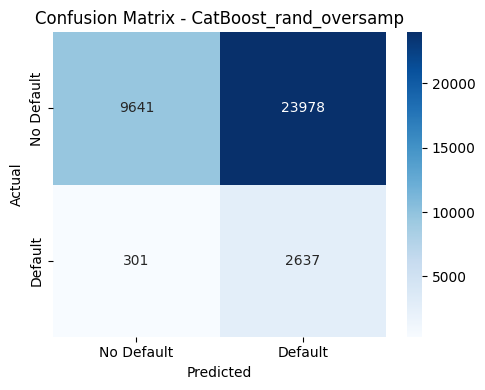

In [80]:
plot_conf_matrix(y_test, y_pred, model_name="CatBoost_rand_oversamp")

In [85]:
par1 = model.get_all_params()

In [86]:
par1

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 11.349645614624023],
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_s

In [91]:
from catboost import CatBoostClassifier, Pool, cv

# Create Pool object
train_pool = Pool(data=X_train_res, label=y_train_res)

# Define parameters
params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'Logloss',
    'eval_metric': 'Recall',
    'random_seed': 42,
    'verbose': False,
    'scale_pos_weight': scale_pos_weight  # Use this for imbalanced data
}

# Perform cross-validation
cv_results = cv(
    pool=train_pool,
    params=params,
    fold_count=5,
    shuffle=True,
    stratified=True,
    early_stopping_rounds=20,
    partition_random_seed=42,
    verbose=False
)

# View final result
print(cv_results.tail())


Training on fold [0/5]

bestTest = 1
bestIteration = 1

Training on fold [1/5]

bestTest = 1
bestIteration = 0

Training on fold [2/5]

bestTest = 1
bestIteration = 1

Training on fold [3/5]

bestTest = 1
bestIteration = 0

Training on fold [4/5]

bestTest = 1
bestIteration = 1

    iterations  test-Recall-mean  test-Recall-std  train-Recall-mean  \
17          17               1.0              0.0                1.0   
18          18               1.0              0.0                1.0   
19          19               1.0              0.0                1.0   
20          20               1.0              0.0                1.0   
21          21               1.0              0.0                1.0   

    train-Recall-std  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
17               0.0           0.264995          0.000417            0.264748   
18               0.0           0.263433          0.000406            0.263192   
19               0.0           0.261858     

In [92]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Let's assume you determined best iteration from CV (or just use 500 as an example)
best_iterations = 500

# Train final model on full training data
final_model = CatBoostClassifier(
    iterations=best_iterations,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Recall',
    random_seed=42,
    scale_pos_weight=scale_pos_weight,
    verbose=0
)

final_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred = final_model.predict(X_test_prepared)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.20      0.33     33619
           1       0.09      0.94      0.17      2938

    accuracy                           0.26     36557
   macro avg       0.53      0.57      0.25     36557
weighted avg       0.90      0.26      0.32     36557

Confusion Matrix:
 [[ 6707 26912]
 [  178  2760]]


In [89]:
from catboost import CatBoostClassifier,Pool,cv 

In [87]:
from catboost import CatBoostClassifier


# Define the CatBoostClassifier
catboost_model_rand_over_hyper = CatBoostClassifier(verbose=0,
                                    scale_pos_weight=scale_pos_weight, 
                                    random_state=42)

#{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 
 #'depth': 4, 'border_count': 32, 'bagging_temperature': 0.5}
# param_distributions = {
#     'depth': [4],
#     'learning_rate': [0.1],
#     'iterations': [ 200],
#     'l2_leaf_reg': [3],
#     'bagging_temperature': [0.5],
#     'border_count': [32]
# }

# Randomized search
random_search1 = RandomizedSearchCV(
    estimator=catboost_model_rand_over_hyper,
    #param_distributions=param_distributions,
    scoring='recall',  # or 'f1_weighted'
    cv=5,
    n_iter=50,              # Try 20 random combinations
    n_jobs=1,
    verbose=3,
    random_state=42
)

# Fit to training data
random_search1.fit(X_train_res, y_train_res)

# Output best results
print("Best Parameters:", random_search1.best_params_)
print("Best Score:", random_search1.best_score_)


TypeError: RandomizedSearchCV.__init__() missing 1 required positional argument: 'param_distributions'